In [30]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, f1_score

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

### Task 1 Data Loading

In [2]:
df = pd.read_csv('archive/diabetes.csv')

print(f"Shape of the dataset: {df.shape}")
df.head(10)


Shape of the dataset: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
5,5,116,74,0,0,25.6,0.201,30,0
6,3,78,50,32,88,31.0,0.248,26,1
7,10,115,0,0,0,35.3,0.134,29,0
8,2,197,70,45,543,30.5,0.158,53,1
9,8,125,96,0,0,0.0,0.232,54,1


In [3]:
df.info()
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


### Task 2 Data Preprocessing

#### class balance checking

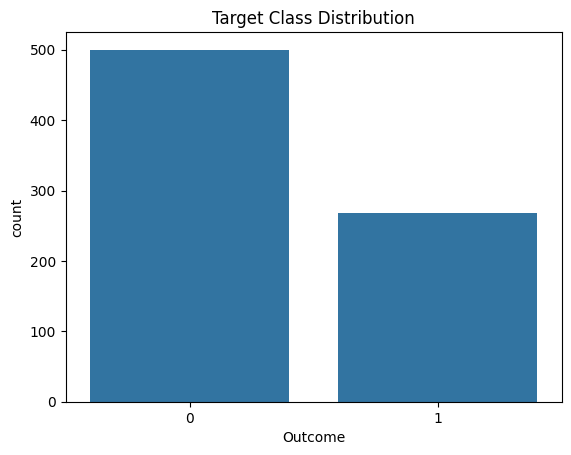

Outcome
0    500
1    268
Name: count, dtype: int64

In [4]:
sns.countplot(x="Outcome", data=df)
plt.title("Target Class Distribution")
plt.show()

df["Outcome"].value_counts()


#### Feature distributions 

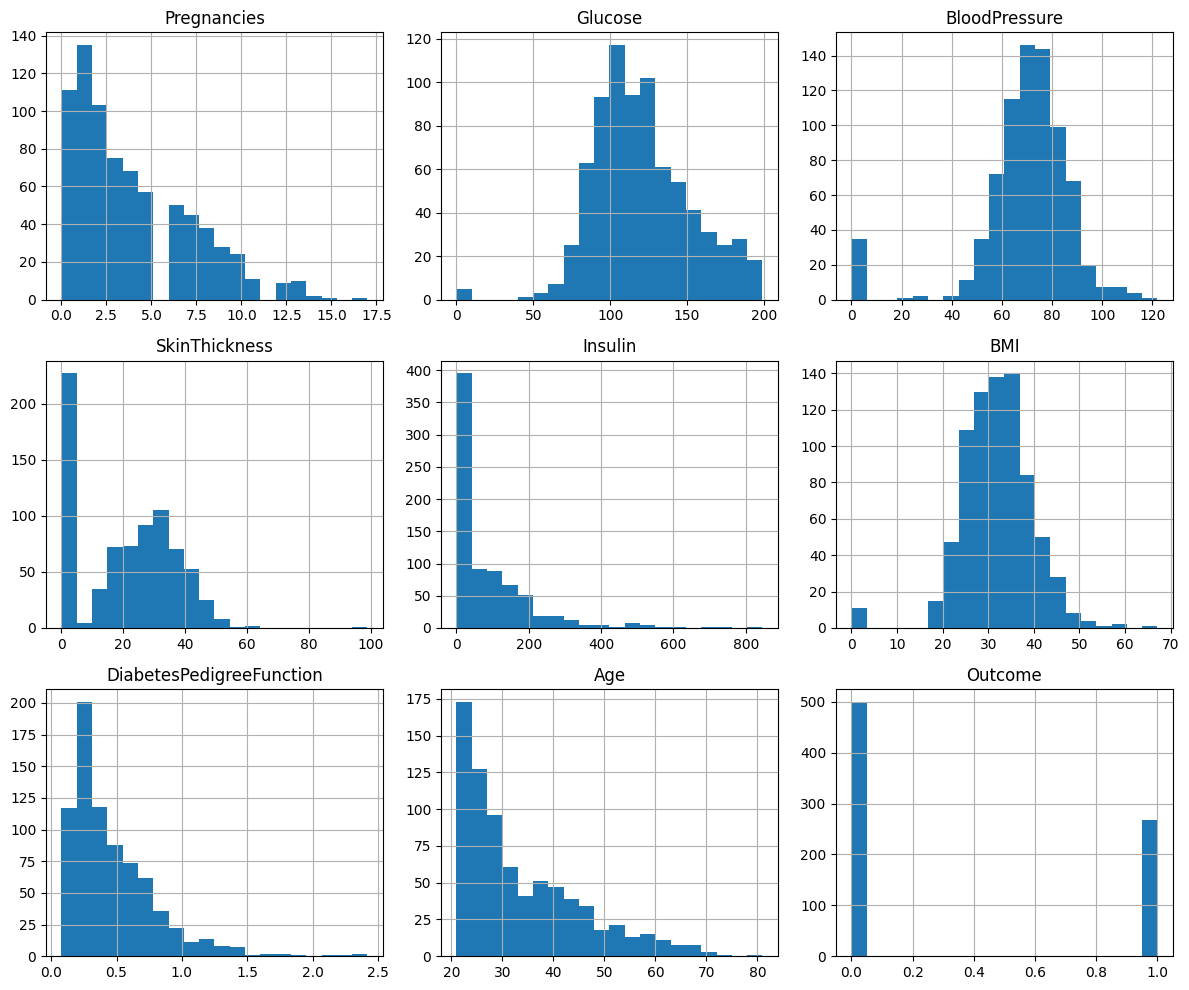

In [5]:
df.hist(figsize=(12,10), bins=20)
plt.tight_layout()
plt.show()


#### outlier detection

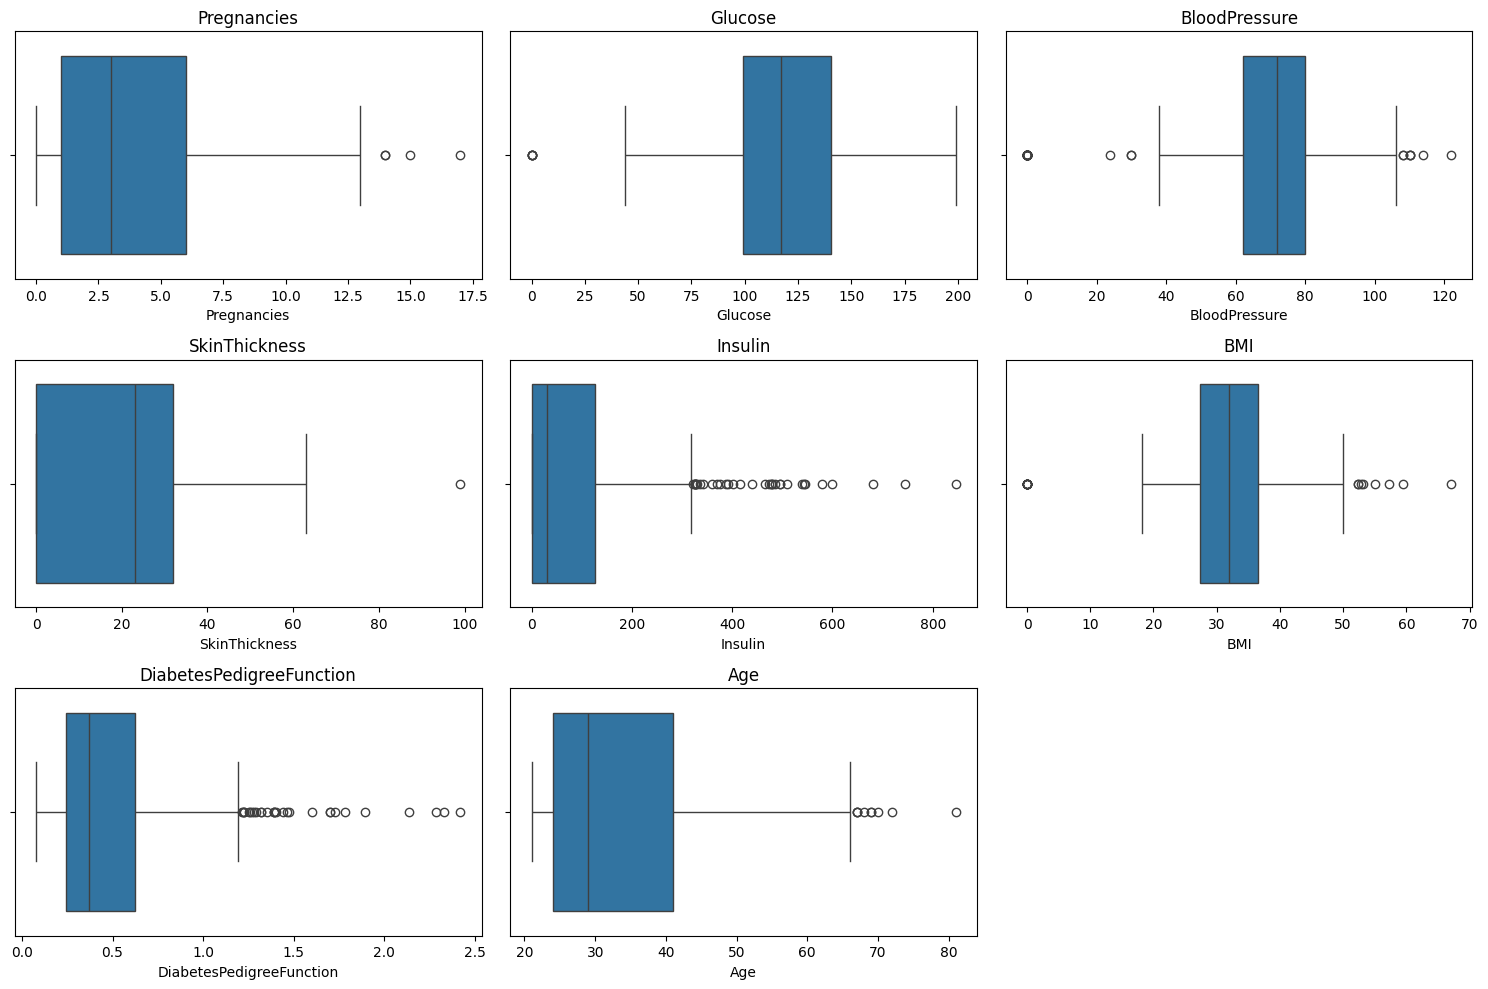

In [6]:
plt.figure(figsize=(15,10))

for i, col in enumerate(df.columns[:-1]):
    plt.subplot(3,3,i+1)
    sns.boxplot(x=df[col])
    plt.title(col)

plt.tight_layout()
plt.show()


Outliers are identified using boxplots. Instead of removing samples due to limited dataset size, feature scaling was later applied to reduce their impact.

#### correlation heatmap

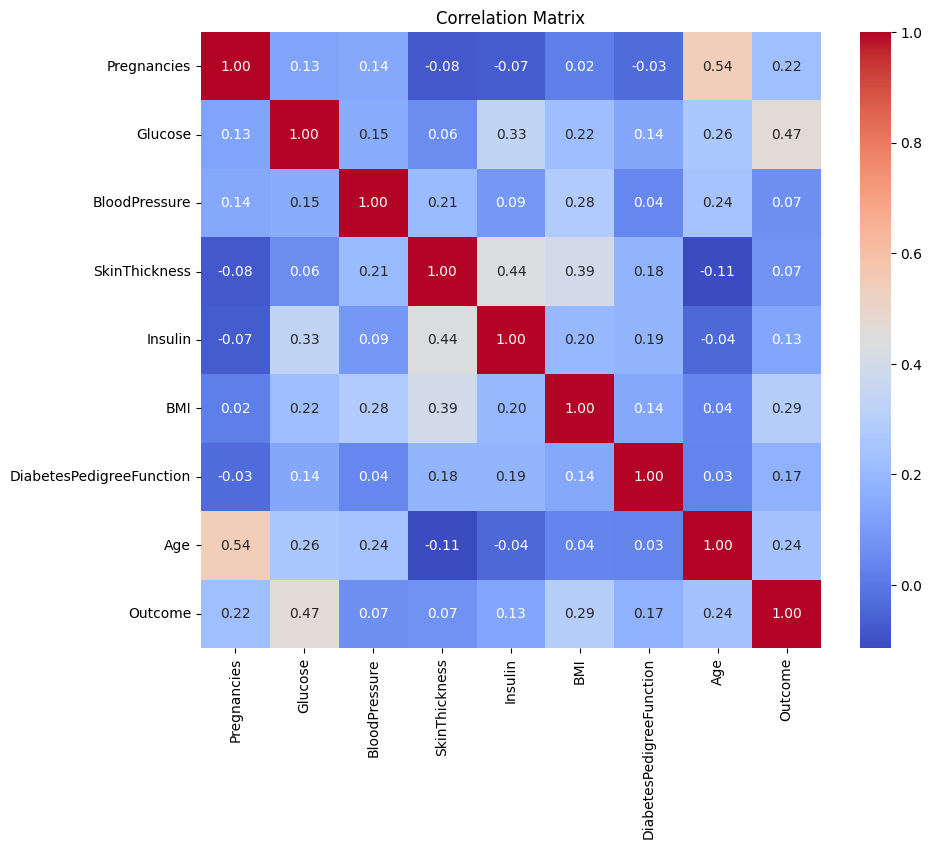

In [7]:
plt.figure(figsize=(10,8))

corr = df.corr()

sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()


stronger correaltion \
Glucose - 0.47 \
BMI - 0.29 \
Age - 0.24 \
Pregnancies - 0.22

weak correlation \
insulin - 0.13 \
DiabetesPedigreeFunction - 0.17

Very weak \
BloodPressure - 0.07 \
SkinThickness - 0.07

#### replacing medically impossible zeros with NaN

In [8]:

zero_cols = ['Glucose','BloodPressure','SkinThickness','Insulin','BMI']

df[zero_cols] = df[zero_cols].replace(0, np.nan)

df[zero_cols].isna().sum()


Glucose            5
BloodPressure     35
SkinThickness    227
Insulin          374
BMI               11
dtype: int64

#### Feature split

In [19]:
X = df.drop("Outcome", axis=1)
y = df["Outcome"]


#### Train–Test Split

In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(614, 8) (154, 8)
(614,) (154,)


### Task 3 Pipeline creation

In [22]:
pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(max_iter=1000))
])

pipeline


,steps,"[('imputer', ...), ('scaler', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,missing_values,nan
,strategy,'median'
,fill_value,None
,copy,True
,add_indicator,False
,keep_empty_features,False
,copy,True


### Task 4 Primary Model Selection

the primary model is already selected in the the pipeline section. Logistic Regression was selected as the primary model because the problem is binary classification with tabular medical data. Logistic Regression is efficient, interpretable, and performs well on small to medium-sized datasets. It also provides stable baseline performance, making it suitable for healthcare-related prediction tasks.

### Task 5 Model Training

In [23]:
pipeline.fit(X_train, y_train)


,steps,"[('imputer', ...), ('scaler', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,missing_values,nan
,strategy,'median'
,fill_value,None
,copy,True
,add_indicator,False
,keep_empty_features,False
,copy,True


### Task 6 cross validation

In [24]:
cv_scores = cross_val_score(
    pipeline,
    X_train,
    y_train,
    cv=5,
    scoring="f1"
)

print("Fold F1:", cv_scores)
print("Mean:", cv_scores.mean())
print("Std:", cv_scores.std())


Fold F1: [0.6746988  0.64935065 0.62337662 0.60869565 0.69230769]
Mean: 0.6496858824779203
Std: 0.031031445184288842


### Task 7 Hyperparameter Tuning 

In [26]:
param_grid = {
    "model__C": [0.01, 0.1, 1, 10, 100]
}

grid = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring="f1",
    n_jobs=-1
)

grid.fit(X_train, y_train)

print(grid.best_params_)
print(grid.best_score_)


{'model__C': 1}
0.6496858824779203


### Task 8 Best Model Selection

In [27]:
best_model = grid.best_estimator_
best_model


,steps,"[('imputer', ...), ('scaler', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,missing_values,nan
,strategy,'median'
,fill_value,None
,copy,True
,add_indicator,False
,keep_empty_features,False
,copy,True


The final model was selected using GridSearchCV. The optimal configuration consisted of Logistic Regression with C=1 combined with median imputation and feature scaling inside a pipeline.

### Task 9 Model Performance Evaluation

In [ ]:
y_pred = best_model.predict(X_test)

print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.75      0.82      0.78       100
           1       0.60      0.50      0.55        54

    accuracy                           0.71       154
   macro avg       0.68      0.66      0.67       154
weighted avg       0.70      0.71      0.70       154

Confusion Matrix:
[[82 18]
 [27 27]]
Accuracy: 0.7077922077922078
ROC AUC Score: 0.66
F1 Score: 0.5454545454545454


#### saving the model

In [31]:
with open("diabetes_model.pkl", "wb") as f:
    pickle.dump(best_model, f)

print("Model saved as diabetes_model.pkl")


Model saved as diabetes_model.pkl
